In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# We need these two classes to set proper ticklabels for Cartopy maps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import pyproj
import dask as dk
import verde as vd
from verde.base import check_fit_input

In [2]:
from dask.distributed import Client, LocalCluster
from dask.distributed import Future

In [3]:
# Fetch the GPS data from the U.S. West coast. 
data = vd.datasets.fetch_california_gps()
region = vd.get_region((data.longitude, data.latitude))
projection = pyproj.Proj(proj='merc', lat_ts=data.latitude.mean())

spacing = 20/60

In [4]:
force_region = vd.project_region(vd.pad_region(region, pad=1), projection)
force_spacings = [spacing*111e3*scale for scale in [2.5, 3, 3.5]]
force_spacings.append(None)
dampings = [10**i for i in range(-8, -3)]
poissons = [-1, 0.5, 1]
print(force_spacings, dampings)

[92500.0, 111000.0, 129500.0, None] [1e-08, 1e-07, 1e-06, 1e-05, 0.0001]


In [5]:
client = Client()

In [6]:
#client.close()

In [28]:
%%time
scores = []
estimators = []
coordinates = projection(data.longitude.values, data.latitude.values)
for poisson in poissons:
    for fspacing in force_spacings:
        for damping in dampings:
            chain = vd.Chain([
                ('mean', vd.BlockMean(spacing*111e3, uncertainty=True)),
                ('trend', vd.VectorTrend(degree=4)),
                ('spline', vd.Vector2D(poisson=poisson, spacing=fspacing, damping=damping,
                                       force_region=force_region))])
            score = vd.cross_val_score(chain, 
                                    coordinates,
                                    (data.velocity_east, data.velocity_north),
                                    (1/data.std_east**2, 1/data.std_north**2),
                                    cv=KFold(3, shuffle=True, random_state=0),
                                    client=client)
            scores.append(client.submit(np.mean, score))
            estimators.append(chain)
best = client.submit(np.argmax, scores)
if isinstance(best, Future):
    best = best.result()
    best_score = client.submit(np.max, scores).result()
else:
    best_score = np.max(scores)
chain = estimators[best]

CPU times: user 5.58 s, sys: 407 ms, total: 5.99 s
Wall time: 26.8 s


In [29]:
print("Best score:", best_score)
print("Best estimator:")
print(chain)

Best score: 0.9668470194036769
Best estimator:
Chain(steps=[('mean', BlockMean(adjust='spacing', center_coordinates=False, region=None,
     spacing=37000.0, uncertainty=True)), ('trend', VectorTrend(degree=4)), ('spline', Vector2D(damping=0.0001,
     force_region=(-11291905.77172092, -10275765.283748921, 2953120.832779573, 4264463.4295444945),
     fudge=1e-05, poisson=0.5, shape=None, spacing=111000.0))])


In [30]:
%%time
chain.fit(projection(data.longitude.values, data.latitude.values),
          (data.velocity_east, data.velocity_north),
          (1/data.std_east**2, 1/data.std_north**2))

CPU times: user 468 ms, sys: 23.7 ms, total: 491 ms
Wall time: 430 ms


Chain(steps=[('mean', BlockMean(adjust='spacing', center_coordinates=False, region=None,
     spacing=37000.0, uncertainty=True)), ('trend', VectorTrend(degree=4)), ('spline', Vector2D(damping=0.0001,
     force_region=(-11291905.77172092, -10275765.283748921, 2953120.832779573, 4264463.4295444945),
     fudge=1e-05, poisson=0.5, shape=None, spacing=111000.0))])

In [25]:
chain = vd.Chain([
    #('mean', vd.BlockMean(spacing*111e3, uncertainty=True)),
    ('mean', vd.BlockReduce(np.mean, spacing*111e3)),
    ('trend', vd.VectorTrend(degree=5)),
    ('spline', vd.Vector2D())])

distributed.nanny - WARNING - Restarting worker


In [26]:
%%time
chain.fit(projection(data.longitude.values, data.latitude.values),
          (data.velocity_east, data.velocity_north))

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


CPU times: user 382 ms, sys: 16.9 ms, total: 398 ms
Wall time: 113 ms


Chain(steps=[('mean', BlockReduce(adjust='spacing', center_coordinates=False,
      reduction=<function mean at 0x7f81a012c1e0>, region=None,
      spacing=37000.0)), ('trend', VectorTrend(degree=5)), ('spline', Vector2D(damping=None,
     force_region=(-11189630.787024967, -10374081.660660725, 3058625.116888401, 4142872.333570974),
     fudge=1e-05, poisson=0.5, shape=None, spacing=None))])

distributed.nanny - WARNING - Restarting worker


In [40]:
grid = chain.grid(region, spacing=spacing, projection=projection,
                  dims=['latitude', 'longitude'])
mask = vd.distance_mask(np.meshgrid(grid.longitude, grid.latitude), (data.longitude, data.latitude), 
                       maxdist=0.5)
grid = grid.where(~mask)

In [41]:
def setup_map(ax, title):
    "Make a map of the given trend component on the given axes"
    ax.set_title(title)
    # Setup the map ticks
    ax.set_xticks(np.arange(-124, -115, 4), crs=crs)
    ax.set_yticks(np.arange(33, 42, 2), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.add_feature(cfeature.LAND, facecolor='gray')
    ax.add_feature(cfeature.OCEAN)
    #ax.set_extent(region, crs=crs)
    ax.set_extent(vd.pad_region(region, pad=0.5), crs=crs)

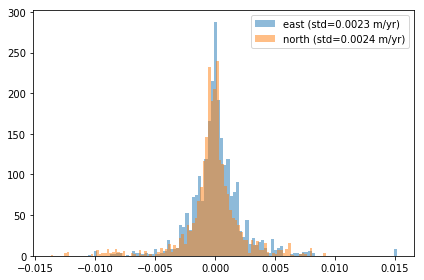

In [42]:
predicted = chain.predict(projection(data.longitude.values, data.latitude.values))
residuals = (data.velocity_east - predicted[0], data.velocity_north - predicted[1])
fig = plt.figure()
ax = plt.axes()
ax.hist(residuals[0], alpha=0.5, bins='auto', label='east (std={:.4f} m/yr)'.format(residuals[0].std()))
ax.hist(residuals[1], alpha=0.5, bins='auto', label='north (std={:.4f} m/yr)'.format(residuals[1].std()))
ax.legend()
plt.tight_layout()

/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/verde/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


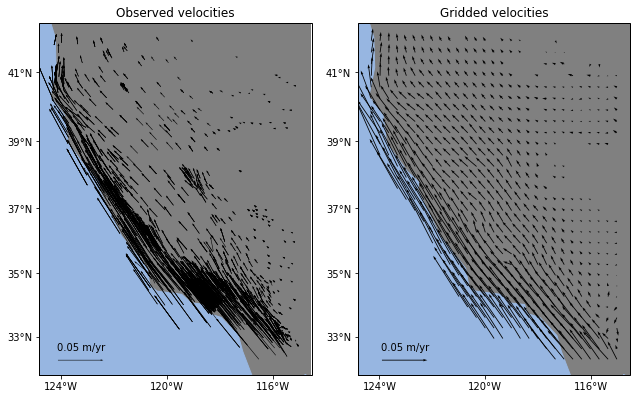

In [50]:
# Make a plot of the data using Cartopy to handle projections and coastlines
fig, axes = plt.subplots(1, 2, figsize=(9, 7),
                         subplot_kw=dict(projection=ccrs.Mercator()))
crs = ccrs.PlateCarree()
# Plot the two trend components
ax = axes[0]
tmp = ax.quiver(data.longitude.values, data.latitude.values,
          data.velocity_east.values, data.velocity_north.values,
          scale=0.3, transform=crs, color='k', width=0.002)
ax.quiverkey(tmp, 0.13, 0.18, 0.05, label='0.05 m/yr', coordinates='figure')
setup_map(ax, 'Observed velocities')

ax = axes[1]
tmp = ax.quiver(grid.longitude.values, grid.latitude.values,
          grid.east_component.values, grid.north_component.values,
          scale=0.3, transform=crs, width=0.003)
ax.quiverkey(tmp, 0.63, 0.18, 0.05, label='0.05 m/yr', coordinates='figure')
setup_map(ax, 'Gridded velocities')

plt.tight_layout()
plt.show()